In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers

dataset = '100K.csv'
dataset_processed = '100K-pp.csv'
preprocessed = True

if(preprocessed is False):
    df = pd.read_csv(dataset,delimiter=',',parse_dates=['pickup_datetime'])
    df = df.drop(['key'], axis=1)

    #Drop if fare == 0
    df = df[df['fare_amount'] > 0]

    df = df.dropna()

    df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
    df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
    df['day'] = pd.DatetimeIndex(df['pickup_datetime']).day
    df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
    df = df.drop(['pickup_datetime'], axis=1)
    
    # Save preprocessed file
    df.to_csv(dataset_processed,index=False)
else:
    df = pd.read_csv(dataset_processed,delimiter=',')
    
print("Finished loading")

Finished loading


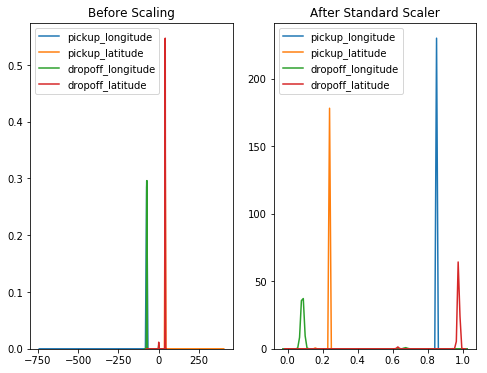

In [166]:
def remove_outlier(data):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    indices = np.argwhere(data[s<3])
    return indices.reshape(len(indices,))


pickup_longitude_ind = remove_outlier(df.filter(['pickup_longitude'],axis=1).values)
#df = df.drop(df.index[pickup_longitude_ind])
df = df.iloc[pickup_longitude_ind,:]

pickup_latitude_ind = remove_outlier(df.filter(['pickup_latitude'],axis=1).values)
#df = df.drop(df.index[pickup_latitude_ind])
df = df.iloc[pickup_latitude_ind,:]

dropoff_longitude_ind = remove_outlier(df.filter(['dropoff_longitude'],axis=1).values)
#df = df.drop(df.index[dropoff_longitude_ind])
df = df.iloc[dropoff_longitude_ind,:]

dropoff_latitude_ind = remove_outlier(df.filter(['dropoff_latitude'],axis=1).values)
#df = df.drop(df.index[dropoff_longitude_ind])
df = df.iloc[dropoff_latitude_ind,:]

df = df.dropna()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6))
ax1.set_title('Before Scaling')
sns.kdeplot(df['pickup_longitude'], ax=ax1)
sns.kdeplot(df['pickup_latitude'], ax=ax1)
sns.kdeplot(df['dropoff_longitude'], ax=ax1)
sns.kdeplot(df['dropoff_latitude'], ax=ax1)

scaler = MinMaxScaler()
for column in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    df[column] = scaler.fit_transform(df[column].values.reshape(-1,1))

ax2.set_title('After Standard Scaler')
sns.kdeplot(df['pickup_longitude'], ax=ax2)
sns.kdeplot(df['pickup_latitude'], ax=ax2)
sns.kdeplot(df['dropoff_longitude'], ax=ax2)
sns.kdeplot(df['dropoff_latitude'], ax=ax2)

plt.show()

In [167]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,month,year,day,hour
0,4.5,0.852537,0.241488,0.086153,0.976981,1,6,2009,15,17
1,16.9,0.852316,0.241467,0.085056,0.977575,1,1,2010,5,16
2,5.7,0.852359,0.241573,0.084961,0.977307,2,8,2011,18,0
3,7.7,0.852353,0.241513,0.084958,0.977371,1,4,2012,21,4
4,5.3,0.852378,0.241587,0.085236,0.977590,1,3,2010,9,7


In [168]:
X = df.drop(['fare_amount','day'], axis=1)  # Features
Y = df['fare_amount']  # Label    

Y = Y.values.reshape(-1,1)
print(Y.shape)

(69085, 1)


In [169]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
print(f"{len(x_train)} train samples")
print(f"{len(x_test)} test samples")

#sc = StandardScaler().fit(x_train)
#x_train = sc.transform(x_train)
#x_test = sc.transform(x_test)

46286 train samples
22799 test samples


In [170]:
model = Sequential()
model.add(Dense(128,input_shape=[8],activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='linear'))

optimizer = optimizers.Adam(lr=0.002)
model.compile(optimizer=optimizer,loss='mse',metrics=['mae','mse'])

history = model.fit(x_train, y_train, epochs=100,validation_split = 0.2, batch_size=128)

Train on 37028 samples, validate on 9258 samples
Epoch 1/100
37028/37028 [==============================] - 2s 56us/step - loss: 1051.1045 - mean_absolute_error: 17.0517 - mean_squared_error: 1051.1045 - val_loss: 180.6502 - val_mean_absolute_error: 8.7798 - val_mean_squared_error: 180.6502
Epoch 2/100
37028/37028 [==============================] - 2s 50us/step - loss: 136.5961 - mean_absolute_error: 7.6364 - mean_squared_error: 136.5961 - val_loss: 145.6098 - val_mean_absolute_error: 6.7306 - val_mean_squared_error: 145.6098
Epoch 3/100
37028/37028 [==============================] - 2s 42us/step - loss: 118.2182 - mean_absolute_error: 6.8922 - mean_squared_error: 118.2182 - val_loss: 140.9807 - val_mean_absolute_error: 6.4822 - val_mean_squared_error: 140.9807
Epoch 4/100
37028/37028 [==============================] - 2s 41us/step - loss: 111.1275 - mean_absolute_error: 6.5821 - mean_squared_error: 111.1275 - val_loss: 123.7032 - val_mean_absolute_error: 5.7567 - val_mean_squared_erro

37028/37028 [==============================] - 1s 38us/step - loss: 93.3865 - mean_absolute_error: 6.0044 - mean_squared_error: 93.3865 - val_loss: 105.0840 - val_mean_absolute_error: 5.8424 - val_mean_squared_error: 105.0840
Epoch 36/100
37028/37028 [==============================] - 1s 39us/step - loss: 93.4515 - mean_absolute_error: 6.0264 - mean_squared_error: 93.4515 - val_loss: 104.1610 - val_mean_absolute_error: 5.9835 - val_mean_squared_error: 104.1610
Epoch 37/100
37028/37028 [==============================] - 1s 36us/step - loss: 93.4046 - mean_absolute_error: 6.0002 - mean_squared_error: 93.4046 - val_loss: 103.7398 - val_mean_absolute_error: 6.1067 - val_mean_squared_error: 103.7398
Epoch 38/100
37028/37028 [==============================] - 1s 37us/step - loss: 93.3038 - mean_absolute_error: 6.0143 - mean_squared_error: 93.3038 - val_loss: 103.8555 - val_mean_absolute_error: 6.0677 - val_mean_squared_error: 103.8555
Epoch 39/100
37028/37028 [==============================]

Mean absolute error on test data 5.8774690368185025


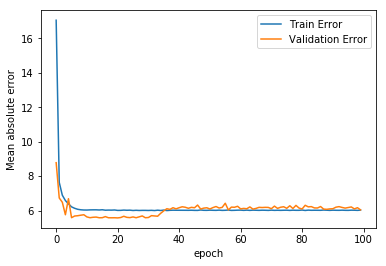

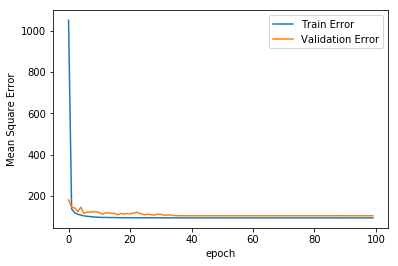

In [171]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Mean absolute error')
plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Validation Error')
plt.legend()


plt.figure()
plt.xlabel('epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
plt.legend()

loss, mae, mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Mean absolute error on test data {mae}")

In [172]:
predictions = model.predict(x_test).flatten()

(0, 206.22591594129756)

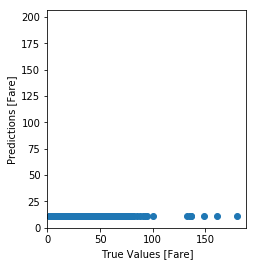

In [173]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values [Fare]')
plt.ylabel('Predictions [Fare]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
